# <center>Bibliotecas utilizadas</center>

In [1]:
from efficient_kan import KAN

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import *

# <center>Pré-processamento dos dados</center>

In [2]:
dataset_path = 'dataset_teste2'

In [3]:
transform_dataset = transforms.Compose(
    [transforms.Resize(size = (164,164)),
     transforms.RandomRotation(degrees=10),
     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
     transforms.ToTensor(),
     transforms.Lambda(lambda x: torch.clamp(x + torch.randn_like(x) * 0.05, 0., 1.)),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
dataset = datasets.ImageFolder(dataset_path, transform = transform_dataset)

In [5]:
print("Informações sobre o Dataset: \n\n", dataset)
print("\nRótulos: ", dataset.class_to_idx)

Informações sobre o Dataset: 

 Dataset ImageFolder
    Number of datapoints: 1000
    Root location: dataset_teste2
    StandardTransform
Transform: Compose(
               Resize(size=(164, 164), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1), shear=[-10.0, 10.0])
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
               ToTensor()
               Lambda()
               Normalize(mean=[0.5], std=[0.5])
           )

Rótulos:  {'NORMAL': 0, 'PNEUMONIA': 1, 'TUBERCULOSE': 2}


In [6]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
all_targets = []
for images, labels in train_loader:
    all_targets.extend(labels.tolist())

nor = []
pne = []
tub = []
for i in range(700):
    if all_targets[i] == 0:
        nor.append(all_targets[i])
    elif all_targets[i] == 1:
        pne.append(all_targets[i])
    elif all_targets[i] == 2:
        tub.append(all_targets[i])

In [9]:
print("!!!Distribuição dos dados de treinamento!!!\n")
print("Normal: ", len(nor))
print("Pneumonia: ", len(pne))
print("Tuberculose: ", len(tub))

!!!Distribuição dos dados de treinamento!!!

Normal:  242
Pneumonia:  232
Tuberculose:  226


# <center>Implementação da arquitetura *efficientKAN*</center>

In [10]:
model = KAN([164*164*3, 164, 64, 3])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

KAN(
  (layers): ModuleList(
    (0-2): 3 x KANLinear(
      (base_activation): ReLU()
    )
  )
)

In [11]:
num_epoch = 250
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

In [12]:
train_losses = []
train_acc = []
correct = 0
total = 0

training_start_time = time.time()

for epoch in range(num_epoch):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 164*164*3).to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    _, predicted = torch.max(outputs.data, 1)

    acc = accuracy_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())
    train_acc.append(acc)

    print(f"Época {epoch + 1}/{num_epoch} - Perda no treinamento: {train_loss:.6f} - Acurácia: {acc:.4f}")

training_time = time.time() - training_start_time
print(f"\nTempo total de treinamento: {training_time:.2f} segundos")

Época 1/250 - Perda no treinamento: 1.246850 - Acurácia: 0.5000
Época 2/250 - Perda no treinamento: 0.777489 - Acurácia: 0.8333
Época 3/250 - Perda no treinamento: 0.634332 - Acurácia: 0.8333
Época 4/250 - Perda no treinamento: 0.589637 - Acurácia: 0.9167
Época 5/250 - Perda no treinamento: 0.539288 - Acurácia: 0.8333
Época 6/250 - Perda no treinamento: 0.497660 - Acurácia: 0.8333
Época 7/250 - Perda no treinamento: 0.555283 - Acurácia: 0.8333
Época 8/250 - Perda no treinamento: 0.511259 - Acurácia: 0.7500
Época 9/250 - Perda no treinamento: 0.421038 - Acurácia: 0.8333
Época 10/250 - Perda no treinamento: 0.425680 - Acurácia: 0.9167
Época 11/250 - Perda no treinamento: 0.457316 - Acurácia: 0.8333
Época 12/250 - Perda no treinamento: 0.492353 - Acurácia: 0.8333
Época 13/250 - Perda no treinamento: 0.460866 - Acurácia: 1.0000
Época 14/250 - Perda no treinamento: 0.403233 - Acurácia: 0.8333
Época 15/250 - Perda no treinamento: 0.385596 - Acurácia: 0.8333
Época 16/250 - Perda no treinament

Text(0.5, 0.98, 'Treinamento')

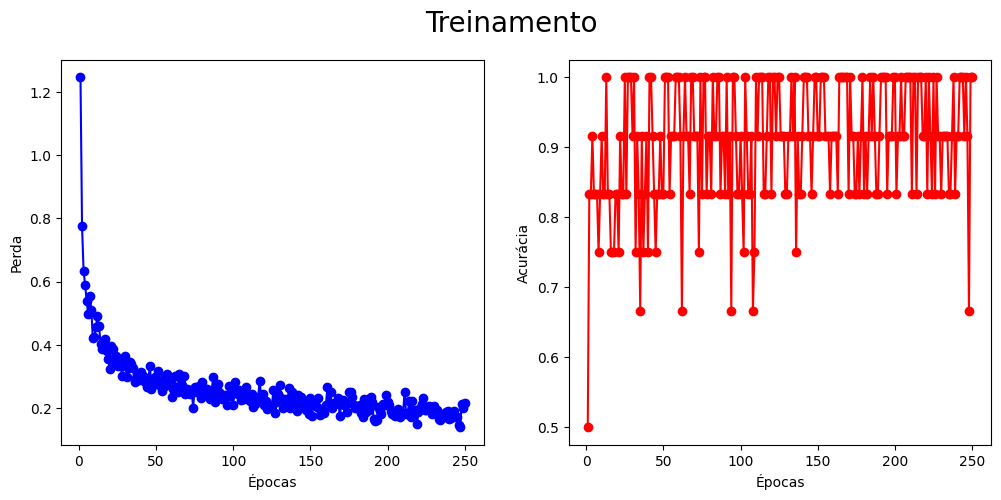

In [13]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

In [14]:
rot_array = []
predt_array = []

model.eval()
    
with torch.no_grad():
        
    for images, labels in test_loader:
        images = images.view(-1, 164*164*3).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        rot_array.extend(labels.cpu().detach().numpy())
        predt_array.extend(predicted.cpu().detach().numpy())

print("!!!Teste finalizado!!!")

!!!Teste finalizado!!!


# <center>Métricas de avaliação</center>

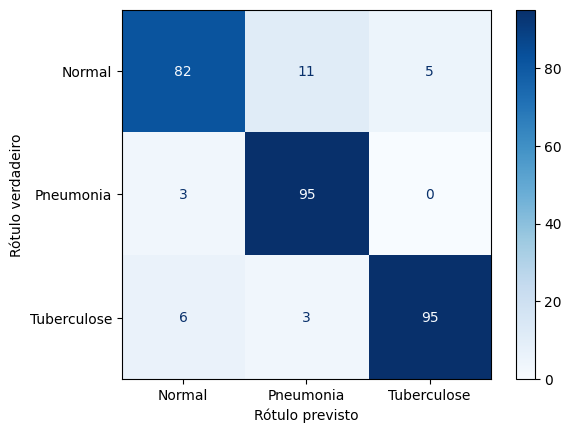

In [15]:
cm = confusion_matrix(rot_array, predt_array)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [16]:
acc = accuracy_score(rot_array, predt_array)
print(f"Acurácia: {acc * 100 :.2f}%")

Acurácia: 90.67%


In [17]:
precision = precision_score(rot_array, predt_array, average='weighted')
print(f"Precisão: {precision * 100 :.2f}%")

Precisão: 90.84%


In [18]:
recall = recall_score(rot_array, predt_array, average='weighted')
print(f"Recall: {recall * 100 :.2f}%")

Recall: 90.67%


In [19]:
f1 = f1_score(rot_array, predt_array, average='weighted')
print(f"F1 Score: {f1 * 100 :.2f}%")

F1 Score: 90.62%
